In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [3]:
# Load and preprocess the data
def load_and_preprocess_data(filepath):
    loc1 = pd.read_csv(filepath)
    loc1['Time'] = pd.to_datetime(loc1['Time'])
    loc1['Year'] = loc1['Time'].dt.year
    loc1['Month'] = loc1['Time'].dt.month
    
    features = ['Year', 'Month', 'temperature_2m', 'relativehumidity_2m', 
                'dewpoint_2m', 'windspeed_10m', 'windspeed_100m', 
                'winddirection_10m', 'winddirection_100m', 'windgusts_10m']
    X = loc1[features]
    y = loc1['Power']
    
    return X, y

In [4]:
# Remove outliers based on Z-scores
def remove_outliers(X, y, threshold=3.0):
    features_to_check = X.columns.difference(['Year', 'Month'])
    z_scores = np.abs(X[features_to_check].apply(zscore))
    mask = (z_scores < threshold).all(axis=1)
    outliers_removed = {feature: np.sum(~mask & (z_scores[feature] >= threshold)) for feature in features_to_check}
    X_clean = X[mask]
    y_clean = y[mask]
    return X_clean, y_clean, outliers_removed

In [5]:
# Visualize distributions before and after outlier removal
def visualize_distributions(X, X_clean):
    for feature in X.columns:
        sns.histplot(X[feature], kde=True)
        plt.title(f"Original Distribution of {feature}")
        plt.show()

        sns.histplot(X_clean[feature], kde=True)
        plt.title(f"Distribution of {feature} After Outlier Removal")
        plt.show()

In [6]:
# Compute and visualize correlation matrix
def plot_correlation_matrix(X, y=None):
    if y is not None:
        data_combined = pd.concat([X, y], axis=1)
        corr_matrix = data_combined.corr()
    else:
        corr_matrix = X.corr()
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Feature Correlation Matrix")
    plt.show()
    
    return corr_matrix

In [7]:
# Calculate Adjusted R²
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

In [8]:
# Train and evaluate Lasso regression model
def train_and_evaluate_lasso(X, y):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define and tune the Lasso model
    lasso = Lasso()
    param_grid = {'alpha': np.logspace(-4, 4, 100)}
    grid_search = GridSearchCV(lasso, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    # Print the best alpha (lambda)
    best_alpha = grid_search.best_params_['alpha']
    print(f"Best alpha (λ): {best_alpha:.4f}")


    # Best Lasso model
    best_lasso = grid_search.best_estimator_
    y_pred = best_lasso.predict(X_test_scaled)

    # Evaluation metrics
    mse_test = mean_squared_error(y_test, y_pred)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)
    adj_r2_test = adjusted_r2(r2_test, X_test_scaled.shape[0], X_test_scaled.shape[1])

    print(f"Test Set Metrics for Improved Lasso Regression:")
    print(f"R²: {r2_test:.4f}")
    print(f"Adjusted R²: {adj_r2_test:.4f}")
    print(f"MSE: {mse_test:.4f}")
    print(f"RMSE: {rmse_test:.4f}")
    print(f"MAE: {mae_test:.4f}")

    # Cross-Validation for the best Lasso model
    cv_results = cross_validate(best_lasso, X, y, cv=10, scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'], return_train_score=False)

    r2_scores = cv_results['test_r2']
    mse_scores = -cv_results['test_neg_mean_squared_error']
    mae_scores = -cv_results['test_neg_mean_absolute_error']

    r2_mean = np.mean(r2_scores)
    mse_mean = np.mean(mse_scores)
    rmse_mean = np.sqrt(mse_mean)
    mae_mean = np.mean(mae_scores)

    r2_std = np.std(r2_scores)
    mse_std = np.std(mse_scores)
    rmse_std = np.sqrt(np.std(mse_scores))
    mae_std = np.std(mae_scores)

    print(f"\nCross-Validation Results for Improved Lasso Regression:")
    print(f"Mean R²: {r2_mean:.4f} ± {r2_std:.4f}")
    print(f"Adjusted R²: {adj_r2_test:.4f} {r2_std:.4f}")
    print(f"Mean MSE: {mse_mean:.4f} ± {mse_std:.4f}")
    print(f"Mean RMSE: {rmse_mean:.4f} ± {rmse_std:.4f}")
    print(f"Mean MAE: {mae_mean:.4f} ± {mae_std:.4f}")


Number of outliers removed from each variable:
dewpoint_2m: 0 outliers
relativehumidity_2m: 11 outliers
temperature_2m: 5 outliers
winddirection_100m: 0 outliers
winddirection_10m: 0 outliers
windgusts_10m: 337 outliers
windspeed_100m: 199 outliers
windspeed_10m: 318 outliers


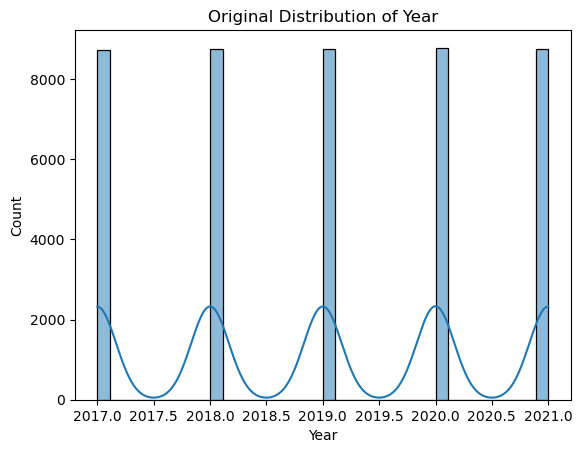

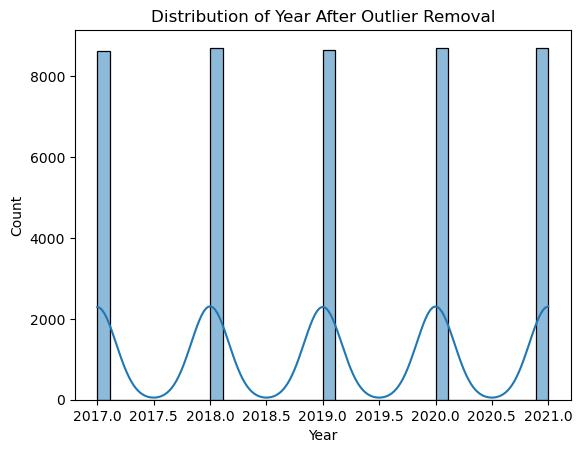

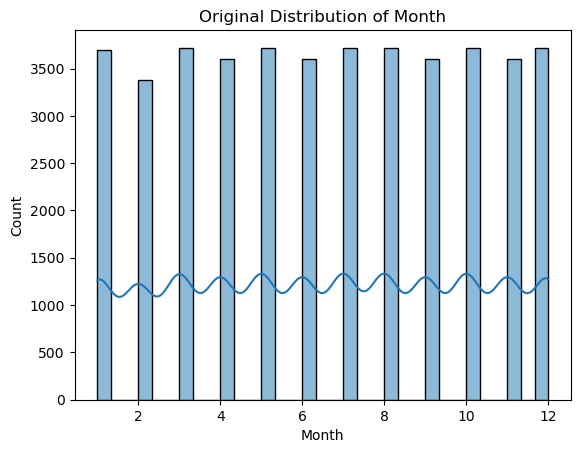

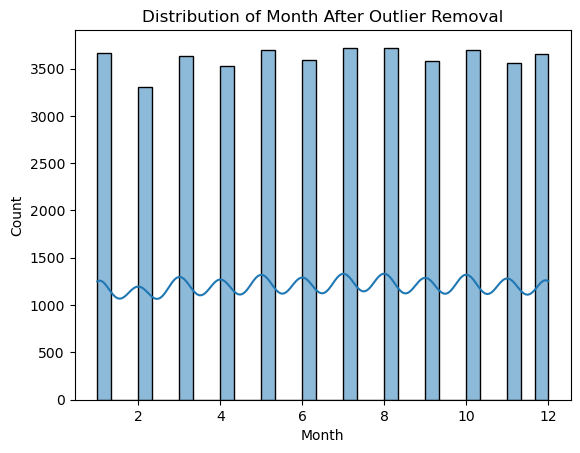

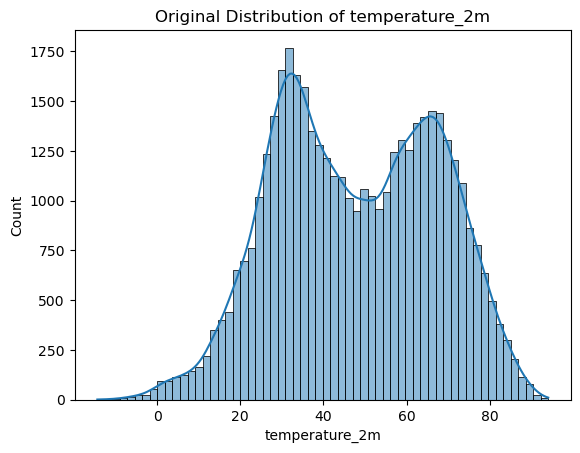

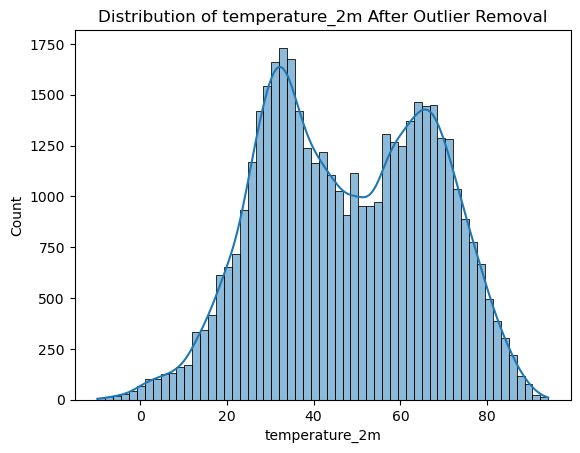

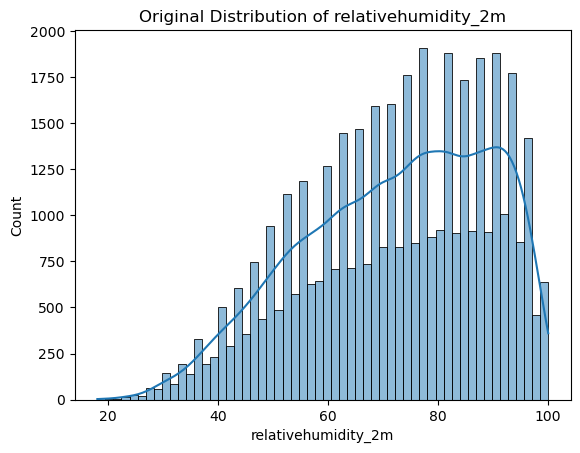

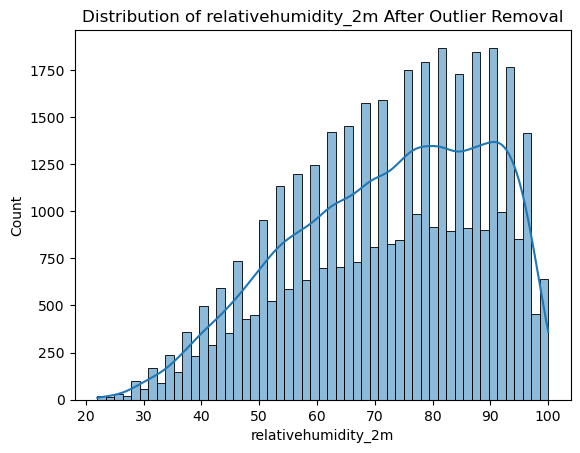

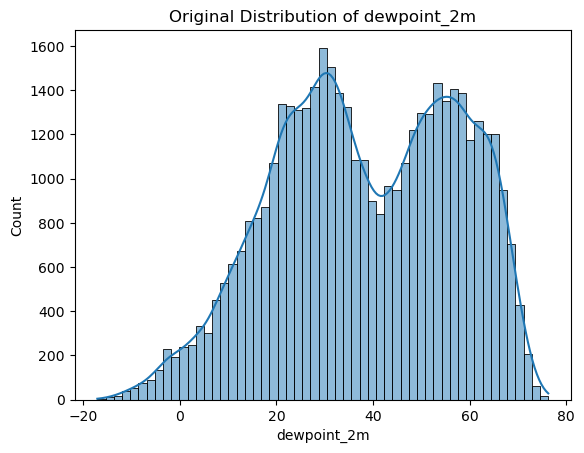

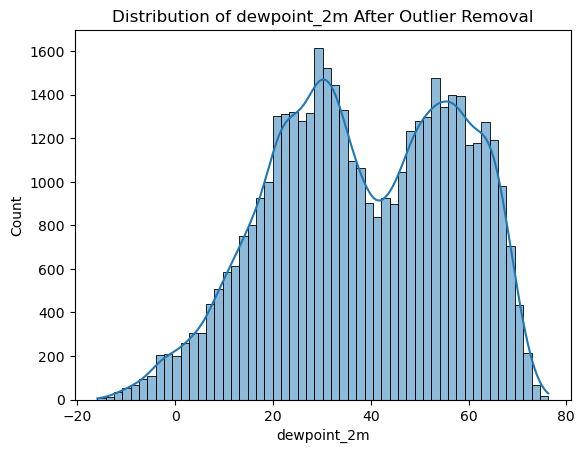

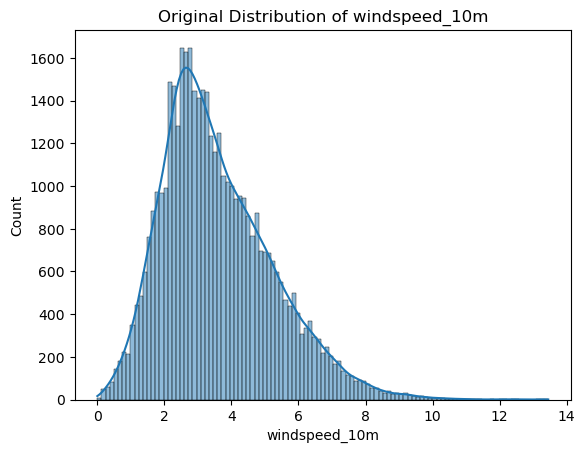

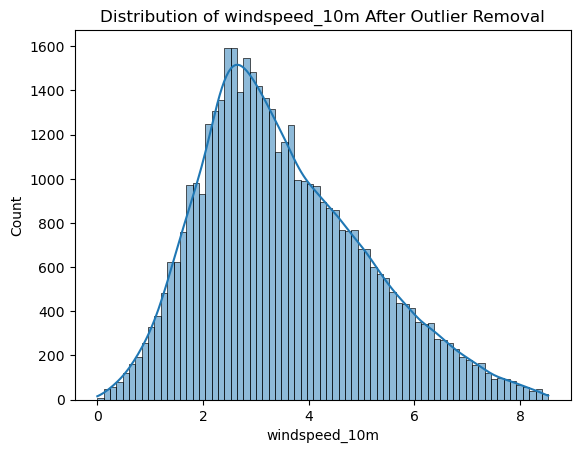

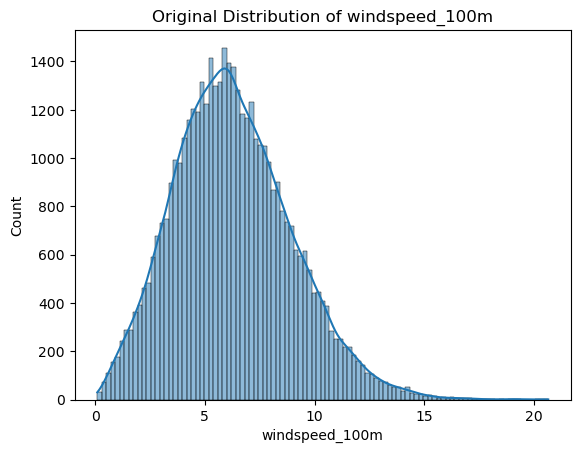

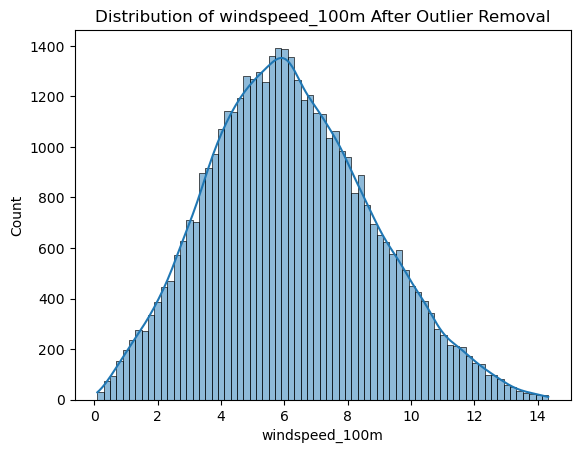

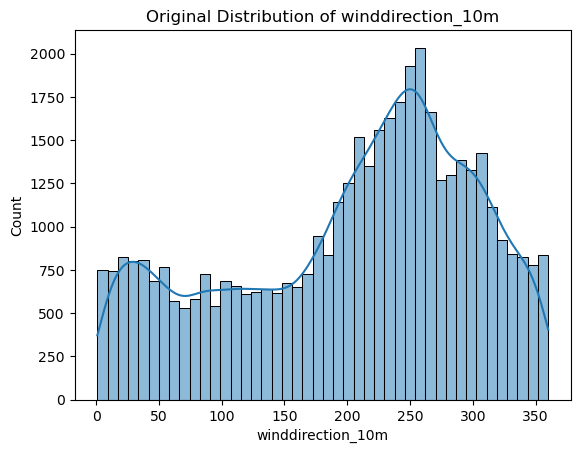

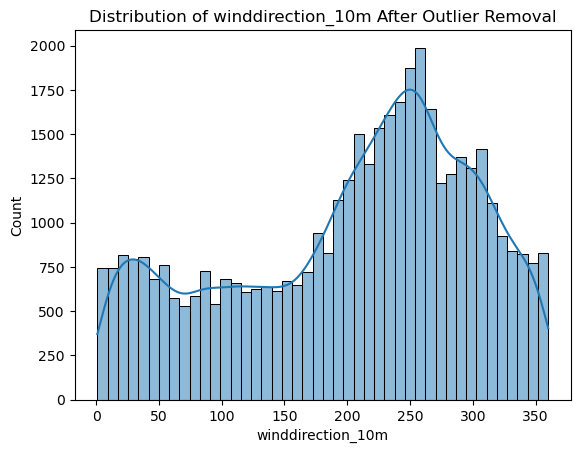

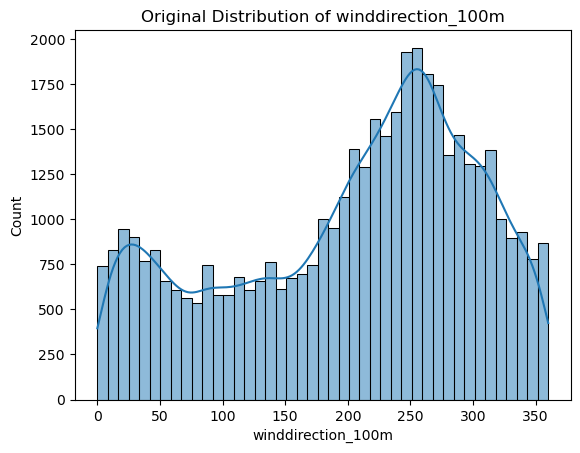

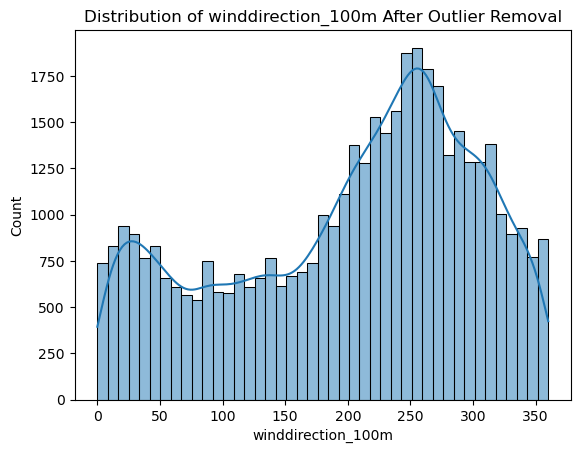

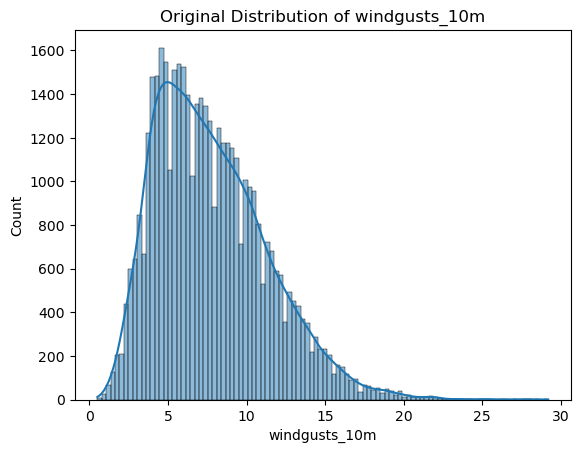

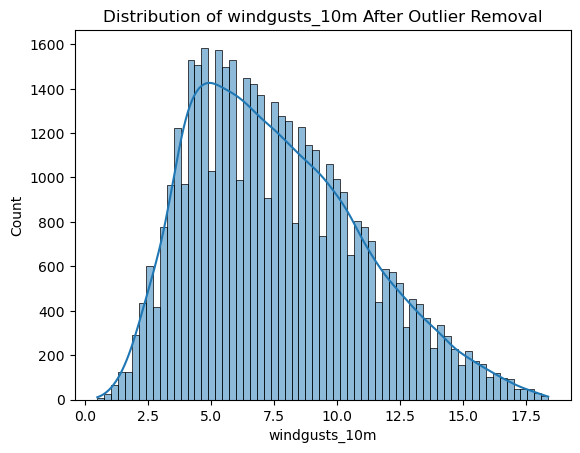

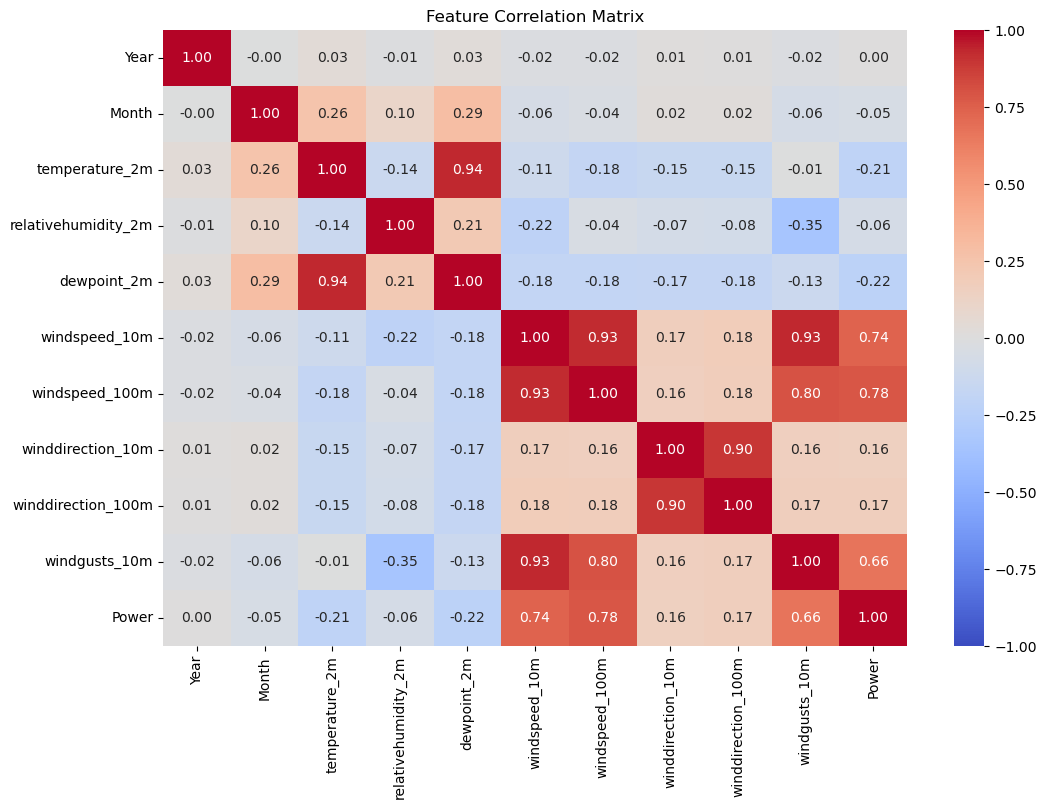

Best alpha (λ): 0.0001
Test Set Metrics for Improved Lasso Regression:
R²: 0.6110
Adjusted R²: 0.6108
MSE: 0.0319
RMSE: 0.1787
MAE: 0.1410

Cross-Validation Results for Improved Lasso Regression:
Mean R²: 0.6132 ± 0.0533
Adjusted R²: 0.6108 0.0533
Mean MSE: 0.0313 ± 0.0052
Mean RMSE: 0.1769 ± 0.0722
Mean MAE: 0.1399 ± 0.0105


In [9]:
# Main script execution
if __name__ == "__main__":
    filepath = 'Location1.csv'
    
    # Load and preprocess data
    X, y = load_and_preprocess_data(filepath)
    
    # Remove outliers
    X_clean, y_clean, outliers_count = remove_outliers(X, y)
    
    # Print number of outliers removed
    print("Number of outliers removed from each variable:")
    for feature, count in outliers_count.items():
        print(f"{feature}: {count} outliers")
    
    # Visualize distributions
    visualize_distributions(X, X_clean)
    
    # Plot correlation matrix
    plot_correlation_matrix(X_clean, y_clean)

    
    # Train and evaluate Lasso model
    selected_features = ['windspeed_100m', 'windspeed_10m', 'windgusts_10m']
    X_selected = X_clean[selected_features]
    train_and_evaluate_lasso(X_selected, y_clean)

In [10]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif(X):
    # Creation of DataFrame for VIF
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
    return vif_data


vif_results = calculate_vif(X_selected)  # Εδώ 'X_selected' είναι το DataFrame των χαρακτηριστικών σου
print(vif_results)


          Feature         VIF
0  windspeed_100m   49.511889
1   windspeed_10m  135.397610
2   windgusts_10m   51.691493


In [11]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np

def calculate_vif(X):
    # Δημιουργία DataFrame για VIF
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    # Υπολογισμός VIF
    vif_data["VIF"] = [sm.OLS(X.iloc[:, i], sm.add_constant(X.drop(X.columns[i], axis=1))).fit().rsquared for i in range(X.shape[1])]
    vif_data["VIF"] = 1 / (1 - vif_data["VIF"])  # Υπολογισμός VIF
    return vif_data

def remove_high_vif_features(X, threshold=10):
    while True:
        vif_results = calculate_vif(X)
        features_to_remove = vif_results[vif_results['VIF'] > threshold]['Feature']
        if len(features_to_remove) == 0:
            break
        X = X.drop(columns=features_to_remove)
        print(f"Removed Features: {features_to_remove.tolist()}")
    return X

def train_and_evaluate_lasso(X, y):
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define and tune the Lasso model
    lasso = Lasso()
    param_grid = {'alpha': np.logspace(-4, 4, 100)}
    grid_search = GridSearchCV(lasso, param_grid, cv=10, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

    # Best Lasso model
    best_lasso = grid_search.best_estimator_
    y_pred = best_lasso.predict(X_test_scaled)

    # Evaluation metrics
    mse_test = mean_squared_error(y_test, y_pred)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, y_pred)
    r2_test = r2_score(y_test, y_pred)

    print(f"\nTest Set Metrics for Lasso Regression with Reduced Features:")
    print(f"R²: {r2_test:.4f}")
    print(f"MSE: {mse_test:.4f}")
    print(f"RMSE: {rmse_test:.4f}")
    print(f"MAE: {mae_test:.4f}")

# Υποθέτουμε ότι έχετε τα δεδομένα σας σε ένα DataFrame 'X' και 'y'
X_selected = X_clean  # Το αρχικό DataFrame με τα χαρακτηριστικά σας
y_clean = y  # Το target σας

# Έλεγχος για NaN
print(f"Dimensions of X_selected: {X_selected.shape}")
print(f"Dimensions of y_clean: {y_clean.shape}")

# Έλεγχος για NaN
if X_selected.isnull().values.any():
    print("X_selected contains NaN values.")
if y_clean.isnull().values.any():
    print("y_clean contains NaN values.")

# Αφαίρεση γραμμών με NaN
X_selected = X_selected.dropna()
y_clean = y_clean.loc[X_selected.index]  # Διατηρούμε μόνο τα index που υπάρχουν στα X_selected

# Επαλήθευση διαστάσεων
print(f"Dimensions of X_selected after cleaning: {X_selected.shape}")
print(f"Dimensions of y_clean after cleaning: {y_clean.shape}")

# Έλεγχος αν οι διαστάσεις είναι ίσες
if X_selected.shape[0] != y_clean.shape[0]:
    print(f"Χαρακτηριστικά: {X_selected.shape[0]}, Στόχος: {y_clean.shape[0]}")
    raise ValueError("Τα X και y πρέπει να έχουν τον ίδιο αριθμό δειγμάτων.")

# Αφαίρεση χαρακτηριστικών με υψηλούς δείκτες VIF
X_reduced = remove_high_vif_features(X_selected)

# Εκπαίδευση και αξιολόγηση της Lasso με τα μειωμένα χαρακτηριστικά
train_and_evaluate_lasso(X_reduced, y_clean)


Dimensions of X_selected: (43344, 10)
Dimensions of y_clean: (43800,)
Dimensions of X_selected after cleaning: (43344, 10)
Dimensions of y_clean after cleaning: (43344,)
Removed Features: ['temperature_2m', 'relativehumidity_2m', 'dewpoint_2m', 'windspeed_10m', 'windgusts_10m']

Test Set Metrics for Lasso Regression with Reduced Features:
R²: 0.6082
MSE: 0.0322
RMSE: 0.1794
MAE: 0.1416


In [25]:
import pandas as pd
print(pd.__version__)

2.0.3
